# Face classifier

## Set up

In [2]:
# 3rd party imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

# Local imports
from facecls import fcaux

In [3]:
seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Load data

In [4]:
data = pd.read_csv("data/age_gender.csv")

## Challenger model: CNN classifier

In [5]:
full_img_vec_list = np.array([fcaux.pxlstring2pxlvec(data, i) for i in range(data.shape[0])])
full_img_array_list = np.array([fcaux.pxlvec2pxlarray(img_vec) for img_vec in full_img_vec_list])
gender = data["gender"].values
ethnicity = data["ethnicity"].values
age = data["age"].values

### Data split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(full_img_array_list, 
                                                    gender,
                                                    test_size = 0.2,
                                                    stratify = gender
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = 0.1,
                                                  stratify = y_train
                                                 )

### Data preprocessing

In [7]:
X_train = X_train.reshape(X_train.shape + (1,))
X_val = X_val.reshape(X_val.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

In [8]:
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_val /= 255
X_test /= 255

In [10]:
target = "gender"
num_classes = data[target].nunique()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

### Building the CNN model (AlexNet architecture)

In [25]:
input_img = Input(shape=(48,48,1))
conv1 = Conv2D(16, (3,3), padding="same", strides=(1,1))(input_img)
activ1 = Activation("relu")(conv1)
conv2 = Conv2D(32, (5,5), strides=(1,1))(activ1)
activ2 = Activation("relu")(conv2)
pool1 = MaxPooling2D(pool_size=(2,2))(activ2)
conv3 = Conv2D(64, (5,5), strides=(1,1))(pool1)
activ3 = Activation("relu")(conv3)
pool2 = MaxPooling2D(pool_size=(2,2))(activ3)
flat = Flatten()(pool2)
dense1 = Dense(128, activation="relu")(flat)

if num_classes == 2:
    out = Dense(num_classes, activation="sigmoid")(dense1)
elif num_classes >= 2:
    out = Dense(num_classes, activation="softmax")(dense1)
else:
    raise ValueError("Number of output classes must be at least 2.")

alex_net = Model(input_img, out)

In [33]:
alex_net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 44, 44, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,184,584 (8.33 MB)

 Trainable params: 728,194 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,456,390 (5.56 MB)

In [26]:
adam = keras.optimizers.Adam()

alex_net.compile(optimizer=adam,
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

In [27]:
an_history = alex_net.fit(X_train, y_train,
                          epochs=7,
                          batch_size=32,
                          validation_data=(X_val, y_val),
                          shuffle=True
                         )             

Epoch 1/7
534/534 ━━━━━━━━━━━━━━━━━━━━ 48s 88ms/step - accuracy: 0.7253 - loss: 0.5182 - val_accuracy: 0.8513 - val_loss: 0.3361
Epoch 2/7
534/534 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.8639 - loss: 0.3002 - val_accuracy: 0.8587 - val_loss: 0.3090
Epoch 3/7
534/534 ━━━━━━━━━━━━━━━━━━━━ 53s 100ms/step - accuracy: 0.8916 - loss: 0.2547 - val_accuracy: 0.8766 - val_loss: 0.2919
Epoch 4/7
534/534 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9047 - loss: 0.2235 - val_accuracy: 0.8693 - val_loss: 0.3115
Epoch 5/7
534/534 ━━━━━━━━━━━━━━━━━━━━ 50s 93ms/step - accuracy: 0.9181 - loss: 0.1985 - val_accuracy: 0.8708 - val_loss: 0.3065
Epoch 6/7
534/534 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9267 - loss: 0.1857 - val_accuracy: 0.8819 - val_loss: 0.3335
Epoch 7/7
534/534 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9384 - loss: 0.1544 - val_accuracy: 0.8798 - val_loss: 0.3474


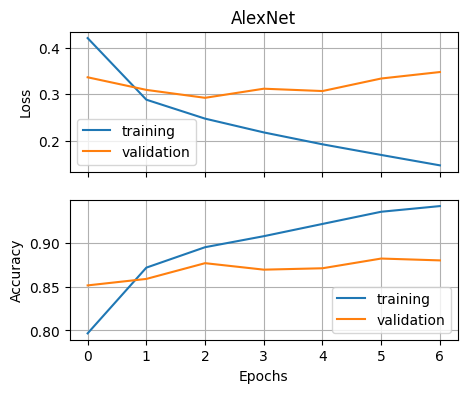

In [34]:
fig, axs = plt.subplots(2,1, figsize=(5,4), sharex=True)
ax = axs[0]
ax.plot(an_history.history["loss"], label="training")
ax.plot(an_history.history["val_loss"], label="validation")
ax.grid(True)
ax.set_xticks(range(7))
ax.set_ylabel("Loss")
ax.set_title("AlexNet")
ax.legend(loc="best")

ax = axs[1]
ax.plot(an_history.history["accuracy"], label="training")
ax.plot(an_history.history["val_accuracy"], label="validation")
ax.grid(True)
ax.set_xticks(range(7))
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(loc="best")

plt.savefig("results/loss_curve_alexnet.png")
plt.show()

In [30]:
y_pred = alex_net.predict(X_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [31]:
y_pred = np.array([np.argmax(i) for i in y_pred])

In [32]:
accuracy_score(y_test, y_pred)

0.8867327568023624